<a href="https://colab.research.google.com/github/yuliiabosher/Adam_Smith_project/blob/main/Congressional_record.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyPDF2
!pip install dask

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.5 MB/s eta 0:00:00


In [3]:
import requests
from google.colab import output
import pprint
import os
from io import BytesIO
import PyPDF2
import re
import datetime
import dask

In [5]:
key = input('enter API key ')
os.environ['Congress_API_Key'] = key
output.clear()

In [6]:
def list_endpoints(year,month,day):
    date_today = datetime.datetime(year, month, day)
    endpoints = []
    for i in range(1, 365):
        past_date = date_today - datetime.timedelta(days=i)
        year = past_date.strftime("%Y")
        month = past_date.strftime("%m")
        day = past_date.strftime("%d")
        endpoint = f"https://api.congress.gov/v3/congressional-record/?y={year}&m={month}&d={day}&api_key={key}"
        endpoints.append(endpoint)
    return endpoints

In [7]:
def find_pdf_links(endpoints_list):
  try:
    links_to_pdfs_with_matches = []
    for i in endpoints_list:
        response = requests.get(i)
        if response.json()['Results']['Issues'] != []:
          link_to_pdf_file = response.json()['Results']['Issues'][0]['Links']['FullRecord']['PDF'][0]['Url']
          pdf_file = requests.get(link_to_pdf_file)
          if pdf_file.content[-7:] == b'\n%%EOF\n':
            pdf_data = BytesIO(pdf_file.content)
            pdf_reader = PyPDF2.PdfReader(pdf_data)
            number_of_pages = len(pdf_reader.pages)
            for j in range(number_of_pages):
              page = pdf_reader.pages[j]
              text = page.extract_text()
              adam_smith_matches = re.findall(r'Adam\sSmith\W*', text)
              if adam_smith_matches != []:
                print(link_to_pdf_file)
                links_to_pdfs_with_matches.append(link_to_pdf_file)
    return links_to_pdfs_with_matches
  except Exception as e:
    print(e)
    return links_to_pdfs_with_matches

delayed_pdf_links = [dask.delayed(find_pdf_links)(list_endpoints(i,5,28)) for i in range(1997,2024)]

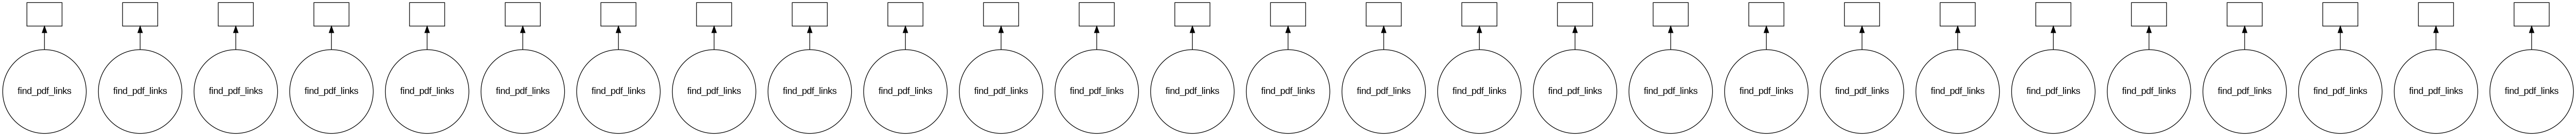

In [12]:
actual_pdf_links = dask.visualize(delayed_pdf_links)
display(actual_pdf_links)

In [13]:
actual_pdf_links = dask.compute(delayed_pdf_links)

https://www.congress.gov/112/crec/2011/05/04/CREC-2011-05-04.pdf
https://www.congress.gov/112/crec/2011/04/08/CREC-2011-04-08.pdf
https://www.congress.gov/112/crec/2011/04/01/CREC-2011-04-01.pdf
https://www.congress.gov/117/crec/2021/03/19/CREC-2021-03-19.pdf
https://www.congress.gov/112/crec/2011/02/14/CREC-2011-02-14.pdf
https://www.congress.gov/117/crec/2021/01/28/167/17/CREC-2021-01-28.pdf
https://www.congress.gov/111/crec/2010/12/16/CREC-2010-12-16.pdf
https://www.congress.gov/111/crec/2010/12/16/CREC-2010-12-16.pdf
https://www.congress.gov/111/crec/2010/12/14/CREC-2010-12-14.pdf
https://www.congress.gov/116/crec/2020/12/21/166/218/CREC-2020-12-21.pdf
https://www.congress.gov/111/crec/2010/11/18/CREC-2010-11-18.pdf
https://www.congress.gov/116/crec/2020/10/01/CREC-2020-10-01.pdf
https://www.congress.gov/116/crec/2020/09/15/CREC-2020-09-15.pdf
https://www.congress.gov/111/crec/2010/07/19/156/106/CREC-2010-07-19.pdf
https://www.congress.gov/111/crec/2010/07/19/156/106/CREC-2010-07-1

https://www.congress.gov/106/crec/2000/04/11/146/45/CREC-2000-04-11.pdf
https://www.congress.gov/115/crec/2017/07/13/CREC-2017-07-13.pdf
https://www.congress.gov/106/crec/2000/03/21/146/32/CREC-2000-03-21.pdf
https://www.congress.gov/106/crec/2000/03/14/146/28/CREC-2000-03-14.pdf
https://www.congress.gov/106/crec/2000/03/14/146/28/CREC-2000-03-14.pdf
https://www.congress.gov/109/crec/2006/05/25/152/67/CREC-2006-05-25.pdf
https://www.congress.gov/109/crec/2006/05/24/152/66/CREC-2006-05-24.pdf
https://www.congress.gov/106/crec/2000/02/10/146/12/CREC-2000-02-10.pdf
https://www.congress.gov/109/crec/2006/05/18/152/62/CREC-2006-05-18.pdf


https://www.congress.gov/106/crec/1999/11/17/145/163/CREC-1999-11-17.pdf
https://www.congress.gov/109/crec/2006/04/27/152/48/CREC-2006-04-27.pdf
https://www.congress.gov/109/crec/2006/04/27/152/48/CREC-2006-04-27.pdf
https://www.congress.gov/106/crec/1999/11/09/145/157/CREC-1999-11-09.pdf
https://www.congress.gov/106/crec/1999/11/09/145/157/CREC-1999-11-09.pdf
https://www.congress.gov/109/crec/2006/04/06/152/43/CREC-2006-04-06.pdf
https://www.congress.gov/109/crec/2006/03/30/152/38/CREC-2006-03-30.pdf
https://www.congress.gov/109/crec/2006/03/29/152/37/CREC-2006-03-29.pdf
https://www.congress.gov/106/crec/1999/11/02/145/152/CREC-1999-11-02.pdf
https://www.congress.gov/106/crec/1999/11/01/145/151/CREC-1999-11-01.pdf
https://www.congress.gov/106/crec/1999/10/28/145/149/CREC-1999-10-28.pdf
https://www.congress.gov/109/crec/2006/03/08/152/29/CREC-2006-03-08.pdf
https://www.congress.gov/109/crec/2006/03/07/152/28/CREC-2006-03-07.pdf
https://www.congress.gov/106/crec/1999/10/27/145/148/CREC-

https://www.congress.gov/111/crec/2009/03/17/CREC-2009-03-17.pdf
https://www.congress.gov/111/crec/2009/03/12/CREC-2009-03-12.pdf
https://www.congress.gov/111/crec/2009/03/12/CREC-2009-03-12.pdf
https://www.congress.gov/111/crec/2009/03/12/CREC-2009-03-12.pdf


https://www.congress.gov/111/crec/2009/02/13/CREC-2009-02-13.pdf
https://www.congress.gov/111/crec/2009/02/13/CREC-2009-02-13.pdf
https://www.congress.gov/111/crec/2009/02/10/CREC-2009-02-10.pdf


https://www.congress.gov/106/crec/2000/09/20/CREC-2000-09-20.pdf
https://www.congress.gov/106/crec/2000/09/14/CREC-2000-09-14.pdf
https://www.congress.gov/106/crec/2000/09/14/CREC-2000-09-14.pdf
https://www.congress.gov/106/crec/2000/09/08/CREC-2000-09-08.pdf
https://www.congress.gov/110/crec/2008/12/11/154/186/CREC-2008-12-11.pdf
https://www.congress.gov/110/crec/2008/12/10/CREC-2008-12-10.pdf
https://www.congress.gov/110/crec/2008/11/20/CREC-2008-11-20.pdf


https://www.congress.gov/110/crec/2008/09/22/CREC-2008-09-22.pdf
https://www.congress.gov/106/crec/2000/06/19/CREC-2000-06-19.pdf


https://www.congress.gov/106/crec/2000/06/15/146/75/CREC-2000-06-15.pdf


https://www.congress.gov/106/crec/2000/06/08/146/70/CREC-2000-06-08.pdf
https://www.congress.gov/106/crec/2000/06/08/146/70/CREC-2000-06-08.pdf
https://www.congress.gov/108/crec/2004/05/21/CREC-2004-05-21.pdf
https://www.congress.gov/108/crec/2004/05/19/CREC-2004-05-19.pdf
https://www.congress.gov/110/crec/2008/07/29/CREC-2008-07-29.pdf
https://www.congress.gov/108/crec/2004/05/12/CREC-2004-05-12.pdf
https://www.congress.gov/110/crec/2008/07/24/CREC-2008-07-24.pdf
https://www.congress.gov/108/crec/2004/05/11/CREC-2004-05-11.pdf
https://www.congress.gov/110/crec/2008/07/23/CREC-2008-07-23.pdf
https://www.congress.gov/108/crec/2004/05/06/CREC-2004-05-06.pdf
https://www.congress.gov/110/crec/2008/07/15/CREC-2008-07-15.pdf
https://www.congress.gov/108/crec/2004/04/28/CREC-2004-04-28.pdf
https://www.congress.gov/108/crec/2004/04/27/CREC-2004-04-27.pdf
https://www.congress.gov/110/crec/2008/07/10/CREC-2008-07-10.pdf
https://www.congress.gov/110/crec/2008/06/20/CREC-2008-06-20.pdf
https://www